In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


### Rat USVs
Source:
- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0175841
- https://datadryad.org/handle/10255/dryad.122340

This dataset has audio and video. R = Rat Number, D = Day, C = Cohort. The dataset is pretty small and a little noisy, but there are visible vocalizations in the spectrograms. 

In [2]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import IPython

In [3]:
from avgn_paper.signalprocessing import spectrogramming as sg

In [4]:
import pdb
from joblib import Parallel, delayed
n_jobs = 10
verbosity = 5

In [5]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### data locations

In [6]:
DSLOC = Path('/mnt/cube/Datasets/rat_voc/')

### Parse Wav info

In [7]:
wavs = list(DSLOC.expanduser().glob('*/*.wav'))
wavs[:3]

[PosixPath('/mnt/cube/Datasets/rat_voc/Vocalization Data - Randomized Days/R1e5.wav'),
 PosixPath('/mnt/cube/Datasets/rat_voc/Vocalization Data - Randomized Days/R5d1.wav'),
 PosixPath('/mnt/cube/Datasets/rat_voc/Vocalization Data - Randomized Days/R5d1c2.wav')]

In [29]:
wavs

[PosixPath('/mnt/cube/Datasets/rat_voc/Vocalization Data - Randomized Days/R1e5.wav'),
 PosixPath('/mnt/cube/Datasets/rat_voc/Vocalization Data - Randomized Days/R5d1.wav'),
 PosixPath('/mnt/cube/Datasets/rat_voc/Vocalization Data - Randomized Days/R5d1c2.wav'),
 PosixPath('/mnt/cube/Datasets/rat_voc/Vocalization Data - Randomized Days/R3e5.wav'),
 PosixPath('/mnt/cube/Datasets/rat_voc/Vocalization Data - Randomized Days/R11e5.wav'),
 PosixPath('/mnt/cube/Datasets/rat_voc/Vocalization Data - Randomized Days/R3e1.wav'),
 PosixPath('/mnt/cube/Datasets/rat_voc/Vocalization Data - Randomized Days/R11e1.wav'),
 PosixPath('/mnt/cube/Datasets/rat_voc/Vocalization Data - Randomized Days/R3d1c2.wav'),
 PosixPath('/mnt/cube/Datasets/rat_voc/Vocalization Data - Randomized Days/R7d1c2.wav'),
 PosixPath('/mnt/cube/Datasets/rat_voc/Vocalization Data - Randomized Days/R1d1.wav'),
 PosixPath('/mnt/cube/Datasets/rat_voc/Vocalization Data - Randomized Days/R3d1.wav'),
 PosixPath('/mnt/cube/Datasets/rat_

In [8]:
len(wavs)

25

In [9]:
rate, data = load_wav(wavs[0])

In [10]:
len(data)/rate, rate

(420.8629225909182, 195313)

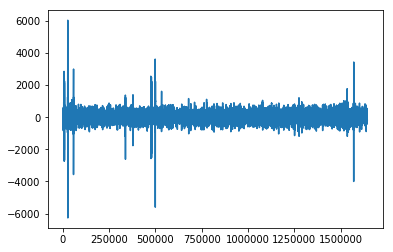

In [11]:
plt.plot(data[::50])

In [22]:
win_length_ms = 10
hop_length_ms = 2
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=4096,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-80,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=128,
    mel_lower_edge_hertz=40000,
    mel_upper_edge_hertz=90000,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)

# create a filter to convolve with the spectrogram
mel_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=hparams.num_mel_bins,
    num_spectrogram_bins=int(hparams.n_fft / 2) + 1,
    sample_rate=rate,
    lower_edge_hertz=hparams.mel_lower_edge_hertz,
    upper_edge_hertz=hparams.mel_upper_edge_hertz,
    dtype=tf.dtypes.float32,
    name=None,
)

# gets the center frequencies of mel bands
mel_f = mel_frequencies(
    n_mels=hparams.num_mel_bins + 2,
    fmin=hparams.mel_lower_edge_hertz,
    fmax=hparams.mel_upper_edge_hertz,
)

# Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
enorm = tf.dtypes.cast(
    tf.expand_dims(
        tf.constant(
            2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[: hparams.num_mel_bins])
        ),
        0,
    ),
    tf.float32,
)

mel_matrix = tf.multiply(mel_matrix, enorm)
mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0)).numpy()

1953.13
390.62600000000003


In [23]:
np.max(data)

6034

In [26]:
spectrogram = sg.spectrogram(data[:rate*30]/ 32768, hparams)
mel_spec = np.dot(spectrogram.T, mel_matrix).T

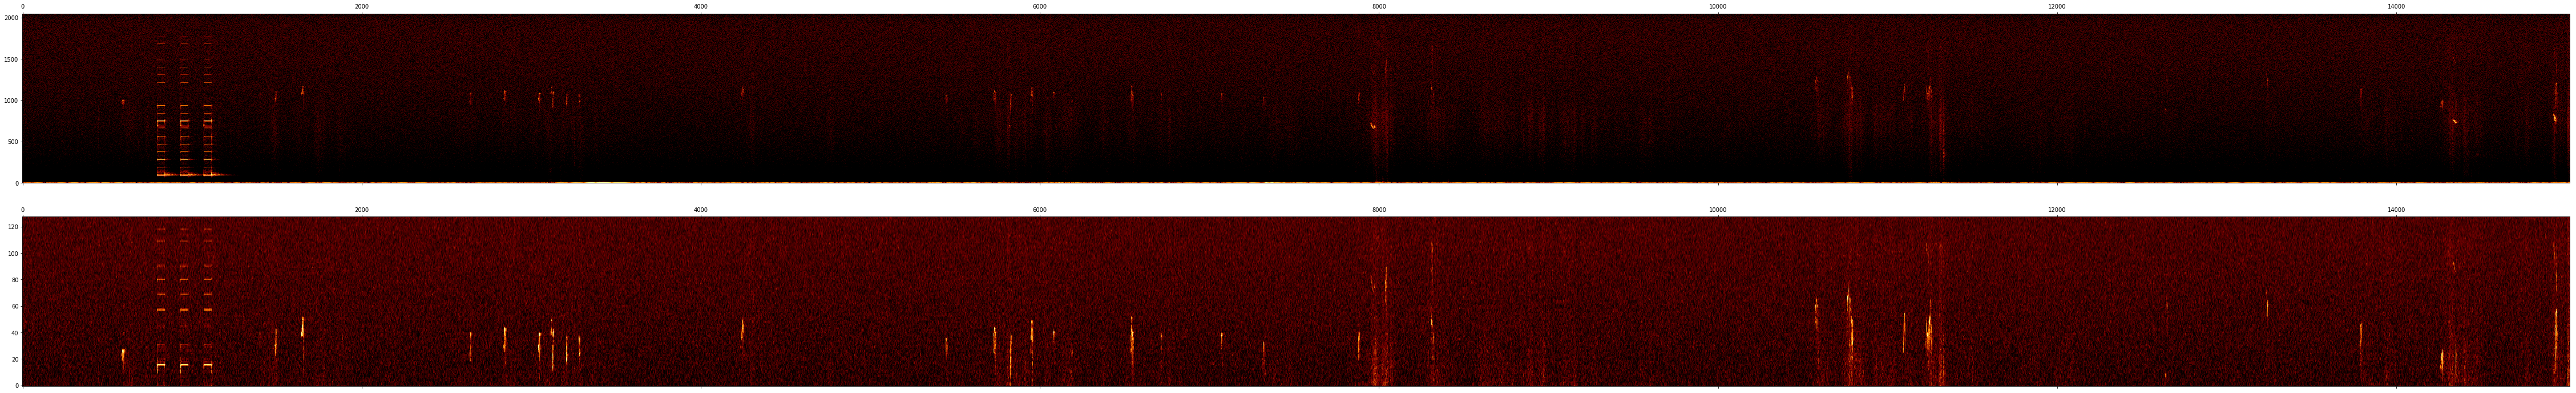

In [27]:
fig, axs = plt.subplots(nrows = 2, figsize=(80,12))
axs[0].matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
axs[1].matshow(mel_spec, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [14]:
for wf in  wavs:
    break

In [15]:
indv_id = wf.stem.split('-')[0]

In [16]:
indv_id

'R1e5'

In [17]:
indv_id.split('e')

['R1', '5']